# Autoencoder Matrix Factorization

In [11]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import keras.backend as K
from keras.models import Model
from keras.layers import (
    Add, 
    Input, 
    Embedding, 
    Dot, 
    Flatten, 
    Dense, 
    Concatenate,
    Dropout, 
    BatchNormalization,
    Activation
)
from keras.regularizers import l2
from keras.optimizers import SGD, Adam
from scipy.sparse import save_npz, load_npz

In [2]:
# config
batch_size = 128
epochs = 20
reg = 0.0001

In [5]:
A = load_npz("data/user_movie_matrix_train.npz")
A_test = load_npz("data/user_movie_matrix_test.npz")
mask = (A > 0) * 1.0
mask_test = (A_test > 0) * 1.0

In [6]:
A_copy = A.copy()
mask_copy = mask.copy()
A_test_copy = A_test.copy()
mask_test_copy = mask_test.copy()

N, M = A.shape
print("N:", N, "M:", M)
print("N // batch_size:", N // batch_size)

# center the data
mu = A.sum() / mask.sum()
print("mu:", mu)

N: 10000 M: 1706
N // batch_size: 78
mu: 3.4218643599211847


In [9]:
def custom_loss(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, 0), dtype='float32')
    diff = y_pred - y_true
    sqdiff = diff * diff * mask
    sse = K.sum(K.sum(sqdiff))
    n = K.sum(K.sum(mask))
    return sse / n


def generator(A, M):
    while True:
        A, M = shuffle(A, M)
        for i in range(A.shape[0] // batch_size + 1):
            upper = min((i+1)*batch_size, A.shape[0])
            a = A[i*batch_size:upper].toarray()
            m = M[i*batch_size:upper].toarray()
            a = a - mu * m # must keep zeros at zero!
            # m2 = (np.random.random(a.shape) > 0.5)
            # noisy = a * m2
            noisy = a # no noise
            yield noisy, a


def test_generator(A, M, A_test, M_test):
    # assumes A and A_test are in corresponding order
    # both of size N x M
    while True:
        for i in range(A.shape[0] // batch_size + 1):
            upper = min((i+1)*batch_size, A.shape[0])
            a = A[i*batch_size:upper].toarray()
            m = M[i*batch_size:upper].toarray()
            at = A_test[i*batch_size:upper].toarray()
            mt = M_test[i*batch_size:upper].toarray()
            a = a - mu * m
            at = at - mu * mt
            yield a, at

In [12]:
# Keras Model

i = Input(shape=(M,))
x = Dropout(0.7)(i)
x = Dense(700, activation='tanh', kernel_regularizer=l2(reg))(x)
# x = Dropout(0.5)(x)
x = Dense(M, kernel_regularizer=l2(reg))(x)

model = Model(i, x)
model.compile(
    loss=custom_loss,
    optimizer=SGD(lr=0.08, momentum=0.9),
    # optimizer='adam',
    metrics=[custom_loss],
)


r = model.fit(
    generator(A, mask),
    validation_data=test_generator(A_copy, mask_copy, A_test_copy, mask_test_copy),
    epochs=epochs,
    steps_per_epoch=A.shape[0] // batch_size + 1,
    validation_steps=A_test.shape[0] // batch_size + 1,
)
print(r.history.keys())

Epoch 1/20
79/79 [==============================] - 2s 16ms/step - loss: 1.1311 - custom_loss: 0.9326 - val_loss: 0.9135 - val_custom_loss: 0.7232
Epoch 2/20
79/79 [==============================] - 1s 15ms/step - loss: 0.8890 - custom_loss: 0.6990 - val_loss: 0.8636 - val_custom_loss: 0.6799
Epoch 3/20
79/79 [==============================] - 1s 15ms/step - loss: 0.8282 - custom_loss: 0.6463 - val_loss: 0.8382 - val_custom_loss: 0.6605
Epoch 4/20
79/79 [==============================] - 1s 15ms/step - loss: 0.7896 - custom_loss: 0.6136 - val_loss: 0.8212 - val_custom_loss: 0.6490
Epoch 5/20
79/79 [==============================] - 1s 15ms/step - loss: 0.7639 - custom_loss: 0.5932 - val_loss: 0.8082 - val_custom_loss: 0.6411
Epoch 6/20
79/79 [==============================] - 1s 15ms/step - loss: 0.7437 - custom_loss: 0.5789 - val_loss: 0.7972 - val_custom_loss: 0.6348
Epoch 7/20
79/79 [==============================] - 1s 15ms/step - loss: 0.7261 - custom_loss: 0.5649 - val_loss: 0.78

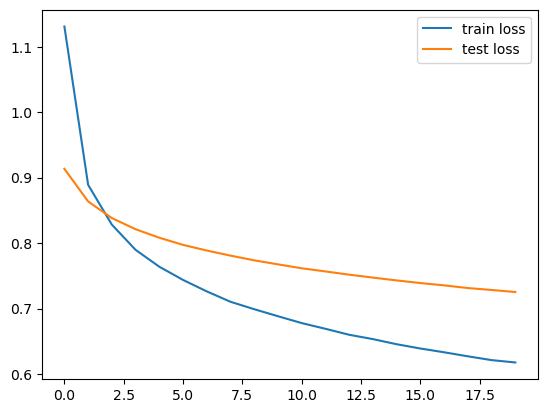

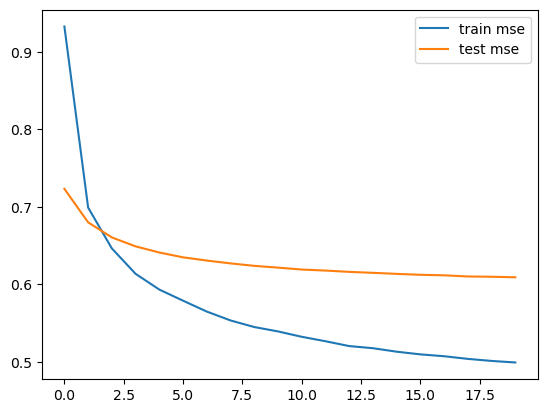

In [14]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

# plot mse
plt.plot(r.history['custom_loss'], label="train mse")
plt.plot(r.history['val_custom_loss'], label="test mse")
plt.legend()
plt.show()